In [150]:
!pip install fredapi

In [151]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from fredapi import Fred
from dotenv import load_dotenv

from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", None)

print("Libraries loaded.")

Libraries loaded.


In [152]:
# Load .env file
load_dotenv('env')

fred_api_key = os.getenv("FRED_API_KEY")
if fred_api_key is None:
    raise ValueError("FRED_API_KEY not found. Check your .env file.")

fred = Fred(api_key=fred_api_key)
print("FRED API connected.")

FRED API connected.


In [153]:
bigmac_path = "big-mac-source-data.csv"
bigmac = pd.read_csv(bigmac_path)
print("Big Mac Index loaded. Rows:", len(bigmac))

bigmac_us = bigmac[bigmac['iso_a3'] == 'USA'].copy()
bigmac_us = bigmac_us[['date', 'local_price']]
bigmac_us['date'] = pd.to_datetime(bigmac_us['date'])
bigmac_us = bigmac_us.set_index('date').resample("ME").ffill()
bigmac_us.head(100)

Big Mac Index loaded. Rows: 2302


,local_price
date,
2000-04-30,2.24
2000-05-31,2.24
2000-06-30,2.24
2000-07-31,2.24
2000-08-31,2.24
...,...
2008-03-31,3.00
2008-04-30,3.00
2008-05-31,3.00


In [154]:
# Pre-2008 single target rate
dfedtar = fred.get_series("DFEDTAR")  # single target rate (discontinued)
dfedtar = dfedtar.to_frame("fed_funds_target_single")
dfedtar.index = pd.to_datetime(dfedtar.index)

# Convert single target into pseudo upper/lower range
dfedtar["fed_funds_lower"] = dfedtar["fed_funds_target_single"]
dfedtar["fed_funds_upper"] = dfedtar["fed_funds_target_single"]
dfedtar["fed_funds_mid"]   = dfedtar["fed_funds_target_single"]

# Keep only columns we'll use
dfedtar = dfedtar[["fed_funds_lower", "fed_funds_upper", "fed_funds_mid"]]

# Post-2008 target range
ffr_upper = fred.get_series("DFEDTARU").to_frame("fed_funds_upper")
ffr_lower = fred.get_series("DFEDTARL").to_frame("fed_funds_lower")

ffr_upper.index = pd.to_datetime(ffr_upper.index)
ffr_lower.index = pd.to_datetime(ffr_lower.index)

# Merge modern upper/lower
ffr_post = pd.concat([ffr_lower, ffr_upper], axis=1)

# Compute midpoint
ffr_post["fed_funds_mid"] = (ffr_post["fed_funds_lower"] + ffr_post["fed_funds_upper"]) / 2

# Stitch pre + post together
ffr_pre = dfedtar[dfedtar.index < "2008-12-01"]
ffr_full = pd.concat([ffr_pre, ffr_post], axis=0)
ffr_full = ffr_full.sort_index()

# Convert to monthly frequency (ME) and forward fill
ffr_full = ffr_full.resample("ME").ffill()

ffr_full.head(10)

,fed_funds_lower,fed_funds_upper,fed_funds_mid
1982-09-30,10.250,10.250,10.250
1982-10-31,9.500,9.500,9.500
1982-11-30,9.000,9.000,9.000
1982-12-31,8.500,8.500,8.500
1983-01-31,8.500,8.500,8.500
1983-02-28,8.500,8.500,8.500
1983-03-31,8.625,8.625,8.625
1983-04-30,8.625,8.625,8.625
1983-05-31,8.750,8.750,8.750
1983-06-30,9.000,9.000,9.000


In [155]:
series_dict = {
    "CPIAUCSL": "cpi",
    "UNRATE": "unemployment_rate",
    "M2SL": "m2_money_supply",
    "DGS10": "treasury_10yr_yield",
    "T10Y2Y": "yield_curve_spread"
}

fred_frames = []

for series_id, colname in series_dict.items():
    data = fred.get_series(series_id)
    df = data.to_frame(name=colname)
    df.index = pd.to_datetime(df.index)
    df = df.resample("ME").mean()
    fred_frames.append(df)

fred_combined = pd.concat(fred_frames, axis=1)
fred_combined.head()

,cpi,unemployment_rate,m2_money_supply,treasury_10yr_yield,yield_curve_spread
1947-01-31,21.48,NaN,NaN,NaN,NaN
1947-02-28,21.62,NaN,NaN,NaN,NaN
1947-03-31,22.00,NaN,NaN,NaN,NaN
1947-04-30,22.00,NaN,NaN,NaN,NaN
1947-05-31,21.95,NaN,NaN,NaN,NaN


In [156]:
#Build FRED-only dataset (no Big Mac involved)

# Step 1: Determine earliest usable date across all FRED series
fred_start = fred_combined.dropna().index.min()
for col in fred_combined.columns:
    print(col, "starts at", fred_combined[col].dropna().index.min())

# Step 2: Build full monthly index from earliest date → latest date
full_index_fred = pd.date_range(
    start=fred_start,
    end=max(ffr_full.index.max(), fred_combined.index.max()),
    freq="ME"
)

# Step 3: Reindex both datasets to this timeline
ffr_fred = ffr_full.reindex(full_index_fred)
macro_fred = fred_combined.reindex(full_index_fred)

# Step 4: Forward-fill (Fed + macro indicators)
ffr_fred = ffr_fred.ffill()
macro_fred = macro_fred.ffill()

# Step 5: Combine into a single dataset
fred_only = pd.concat([ffr_fred, macro_fred], axis=1)

# Optional: Drop rows if any leading NaNs slipped in
fred_only = fred_only.dropna()

fred_only.head(20)

cpi starts at 1947-01-31 00:00:00
unemployment_rate starts at 1948-01-31 00:00:00
m2_money_supply starts at 1959-01-31 00:00:00
treasury_10yr_yield starts at 1962-01-31 00:00:00
yield_curve_spread starts at 1976-06-30 00:00:00


,fed_funds_lower,fed_funds_upper,fed_funds_mid,cpi,unemployment_rate,m2_money_supply,treasury_10yr_yield,yield_curve_spread
1982-09-30,10.2500,10.2500,10.2500,97.7,10.1,1858.4,12.339048,0.555714
1982-10-31,9.5000,9.5000,9.5000,98.1,10.4,1869.7,10.906500,0.719000
1982-11-30,9.0000,9.0000,9.0000,98.0,10.8,1883.7,10.550526,0.754737
1982-12-31,8.5000,8.5000,8.5000,97.7,10.8,1905.9,10.540000,0.877727
1983-01-31,8.5000,8.5000,8.5000,97.9,10.4,1959.4,10.457143,1.129524
1983-02-28,8.5000,8.5000,8.5000,98.0,10.4,1996.8,10.724737,1.088421
1983-03-31,8.6250,8.6250,8.6250,98.1,10.3,2015.2,10.506522,0.850435
1983-04-30,8.6250,8.6250,8.6250,98.8,10.2,2028.6,10.400000,0.832000
1983-05-31,8.7500,8.7500,8.7500,99.2,10.1,2043.1,10.380000,0.890952
1983-06-30,9.0000,9.0000,9.0000,99.4,10.1,2053.5,10.848636,0.666818


In [157]:
# Align all datasets to Big Mac Index availability

# 1. Big Mac determines the earliest valid date
bigmac_start = bigmac_us.dropna().index.min()

# 2. Full monthly index from Big Mac start → most recent data available
full_index = pd.date_range(
    start=bigmac_start,
    end=bigmac_us.index.max(),
    freq="ME"
)

# 3. Reindex all datasets to this unified timeline
ffr = ffr_full.reindex(full_index)
bigmac_us = bigmac_us.reindex(full_index)
fred_combined = fred_combined.reindex(full_index)

# 4. Forward-fill everything except Big Mac (already correct frequency)
ffr = ffr.ffill()
fred_combined = fred_combined.ffill()

# 5. Final unified dataset
combined = pd.concat([ffr, bigmac_us, fred_combined], axis=1)
combined = combined.sort_index()
combined.tail(20)

,fed_funds_lower,fed_funds_upper,fed_funds_mid,local_price,cpi,unemployment_rate,m2_money_supply,treasury_10yr_yield,yield_curve_spread
2023-06-30,5.00,5.25,5.125,5.36,304.099,3.6,20782.7,3.748095,-0.891429
2023-07-31,5.25,5.50,5.375,5.58,304.615,3.5,20772.0,3.899500,-0.929000
2023-08-31,5.25,5.50,5.375,5.58,306.138,3.7,20746.9,4.167826,-0.733913
2023-09-30,5.25,5.50,5.375,5.58,307.374,3.8,20720.4,4.379000,-0.643000
2023-10-31,5.25,5.50,5.375,5.58,307.653,3.9,20687.3,4.798095,-0.269524
2023-11-30,5.25,5.50,5.375,5.58,308.087,3.7,20696.7,4.502857,-0.379524
2023-12-31,5.25,5.50,5.375,5.58,308.735,3.8,20701.3,4.020000,-0.437000
2024-01-31,5.25,5.50,5.375,5.69,309.794,3.7,20773.1,4.058095,-0.264762
2024-02-29,5.25,5.50,5.375,5.69,311.022,3.9,20861.1,4.207500,-0.336500
2024-03-31,5.25,5.50,5.375,5.69,312.107,3.9,20900.9,4.208500,-0.379500


In [158]:
missing_report = combined.isna().sum()
missing_report

# missing_report = fred_only.isna().sum()
# missing_report

combined_output_path = "combined_raw.csv"
combined.to_csv(combined_output_path)
print("Raw dataset saved to:", combined_output_path)

output_path = "fred_only.csv"
fred_only.to_csv(output_path)
print("Raw dataset saved to:", output_path)

Raw dataset saved to: combined_raw.csv
Raw dataset saved to: fred_only.csv


In [159]:
# Load raw csv data
combined = pd.read_csv("combined_raw.csv", index_col=0, parse_dates=True)
fred_only = pd.read_csv("fred_only.csv", index_col=0, parse_dates=True)

In [173]:

USE_BIGMAC = [False, True]

# Fed columns
fed_cols = ["fed_funds_mid", "fed_funds_upper", "fed_funds_lower"]
for TF_val in USE_BIGMAC:
  for TARGET in fed_cols:

    df = combined.copy() if TF_val else fred_only.copy()

    # Create target column
    X = df.drop(columns=fed_cols)
    df["target"] = df[TARGET].copy()
    y = df["target"]

    original_cols = X.columns.tolist()


    def add_lags(data, cols, lags=[1, 3, 6, 12]):
      new_cols = {}
      for col in cols:
          for lag in lags:
              new_cols[f"{col}_lag{lag}"] = data[col].shift(lag)
      return data.join(pd.DataFrame(new_cols, index=data.index))

    def add_pct_change(data, cols, periods=[1, 3, 12]):
      new_cols = {}
      for col in cols:
          for p in periods:
              new_cols[f"{col}_pct_change{p}"] = data[col].pct_change(p)
      return data.join(pd.DataFrame(new_cols, index=data.index))

    def add_rolling_means(data, cols, windows=[3, 6, 12]):
      new_cols = {}
      for col in cols:
          for w in windows:
            new_cols[f"{col}_rollmean{w}"] = data[col].rolling(window=w).mean()
      return data.join(pd.DataFrame(new_cols, index=data.index))

    # Add lag features
    X = add_lags(X, original_cols)

    # Add percent change features
    X = add_pct_change(X, original_cols)

    # Add rolling mean features
    X = add_rolling_means(X, original_cols)


    if "local_price" in X.columns:
      X['local_price_trend'] = X['local_price'].diff()

    if "yield_curve_spread" in X.columns:
      X['yield_curve_spread_change'] = X['yield_curve_spread'].diff()

    if "cpi" in X.columns and "unemployment_rate" in X.columns:
      X['cpi_unemp_interaction'] = X['cpi'] * X['unemployment_rate']


    X = X.dropna()
    y = y.loc[X.index]  # align target with valid feature rows

    # Combine for convenience
    df_engineered = X.copy()
    df_engineered["target"] = y

    print("Original rows:", len(df))
    print("Rows after feature engineering:", len(df_engineered))
    print("Columns in final dataset:", df_engineered.shape[1])

    if TF_val:
      big_mac = "big_mac"
    else:
      big_mac = "no_big_mac"

    X.to_csv(f"X_features_{TARGET}_{big_mac}.csv")
    y.to_csv(f"y_target_{TARGET}_{big_mac}.csv")

Original rows: 520
Rows after feature engineering: 508
Columns in final dataset: 58
Original rows: 520
Rows after feature engineering: 508
Columns in final dataset: 58
Original rows: 520
Rows after feature engineering: 508
Columns in final dataset: 58
Original rows: 298
Rows after feature engineering: 286
Columns in final dataset: 70
Original rows: 298
Rows after feature engineering: 286
Columns in final dataset: 70
Original rows: 298
Rows after feature engineering: 286
Columns in final dataset: 70


In [174]:
DATASETS = {
    "big_mac": {
        "mid":   ("X_features_fed_funds_mid_big_mac.csv",   "y_target_fed_funds_mid_big_mac.csv"),
        "lower": ("X_features_fed_funds_lower_big_mac.csv", "y_target_fed_funds_lower_big_mac.csv"),
        "upper": ("X_features_fed_funds_upper_big_mac.csv", "y_target_fed_funds_upper_big_mac.csv"),
    },
    "no_big_mac": {
        "mid":   ("X_features_fed_funds_mid_no_big_mac.csv",   "y_target_fed_funds_mid_no_big_mac.csv"),
        "lower": ("X_features_fed_funds_lower_no_big_mac.csv", "y_target_fed_funds_lower_no_big_mac.csv"),
        "upper": ("X_features_fed_funds_upper_no_big_mac.csv", "y_target_fed_funds_upper_no_big_mac.csv"),
    }
}


# SELECT FEATURE SET
USE_BIG_MAC = False         # True = Big Mac engineered set, False = FRED-only
TARGET_VERSION = "upper"     # "mid", "lower", or "upper"

subset = "big_mac" if USE_BIG_MAC else "no_big_mac"

X_file, y_file = DATASETS[subset][TARGET_VERSION]

print("Using X file:", X_file)
print("Using y file:", y_file)


# LOAD DATA
X = pd.read_csv(f"{X_file}", index_col=0, parse_dates=True)
y = pd.read_csv(f"{y_file}", index_col=0, parse_dates=True).iloc[:, 0]

print("X shape:", X.shape)
print("y shape:", y.shape)
print(X.index.equals(y.index))   # Should be True
print("Start:", X.index.min(), "| End:", X.index.max())

Using X file: X_features_fed_funds_upper_no_big_mac.csv
Using y file: y_target_fed_funds_upper_no_big_mac.csv
X shape: (508, 57)
y shape: (508,)
True
Start: 1983-09-30 00:00:00 | End: 2025-12-31 00:00:00


In [175]:
# Chronological split
split_index = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

In [176]:
baseline_pred = np.full_like(y_test, y_train.mean(), dtype=float)
baseline_pred_persist = np.full_like(y_test, y_train.iloc[-1], dtype=float)

def evaluate(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": rmse,
        "R2": r2_score(y_true, y_pred)
    }

print("Mean baseline:", evaluate(y_test, baseline_pred))
print("Persistence baseline:", evaluate(y_test, baseline_pred_persist))

Mean baseline: {'MAE': 3.9022836912542793, 'RMSE': np.float64(4.3382347955660325), 'R2': -4.2388237365843375}
Persistence baseline: {'MAE': 1.5361111111111112, 'RMSE': np.float64(2.0891585227869456), 'R2': -0.2149278002333519}


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.581e+01, tolerance: 1.238e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.322e+01, tolerance: 1.238e-01
  model = cd_fast.enet_coordinate_descent(


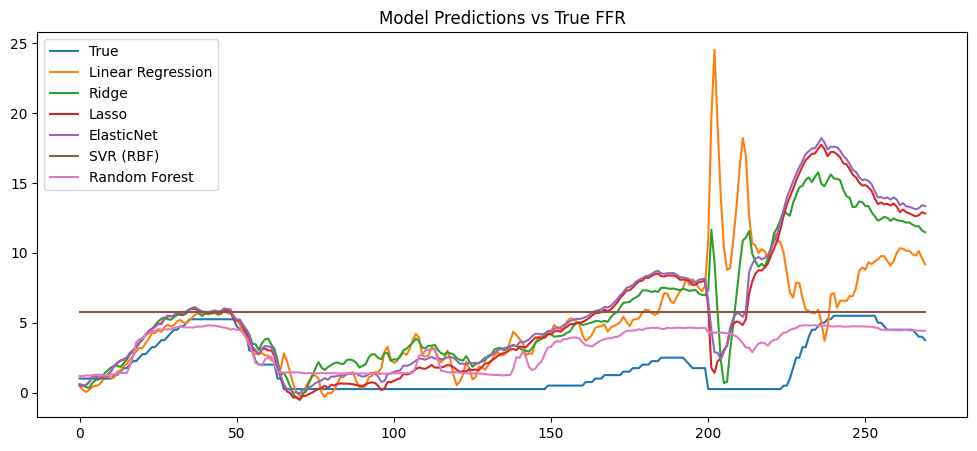

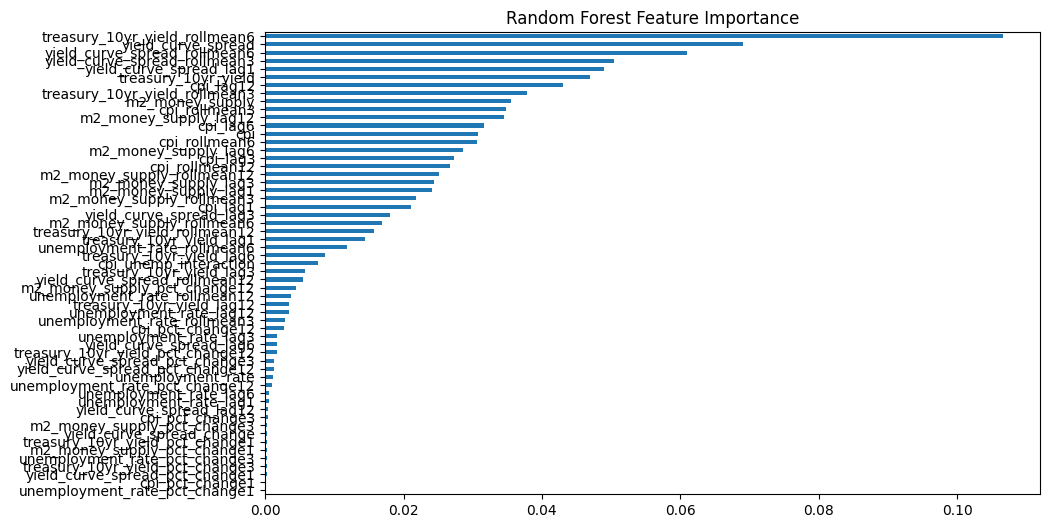

In [177]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01),
    "ElasticNet": ElasticNet(alpha=0.01, l1_ratio=0.5),
    "SVR (RBF)": SVR(kernel="rbf", C=10, gamma=0.1),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    results[name] = evaluate(y_test, preds)

pd.DataFrame(results).T

plt.figure(figsize=(12,5))
plt.plot(y_test.values, label="True")

for name, model in models.items():
    pred = model.predict(X_test)
    plt.plot(pred, label=name)

plt.legend()
plt.title("Model Predictions vs True FFR")
plt.show()

rf = models["Random Forest"]
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values().plot(kind="barh", figsize=(10,6))
plt.title("Random Forest Feature Importance")
plt.show()

pd.DataFrame(results).T.to_csv("model_performance.csv")